<a href="https://colab.research.google.com/github/xinyiff/Project-on-StyleGAN/blob/main/StyleGAN2-ADA-Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This module makes use of PyTorch framework rather than Keras/TensorFlow. While there are versions of [StyleGAN2-ADA that work with TensorFlow 1.0](https://github.com/jeffheaton/t81_558_deep_learning/blob/5e2528a08c302c82919001a3c3c8364c29c1b999/t81_558_class_07_3_style_gan.ipynb), NVIDIA has switched to PyTorch. 

In [1]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Next, clone StyleGAN2 ADA PyTorch from GitHub.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 2.99 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 112kB 7.2MB/s 


Verify that StyleGAN has been cloned.

In [ ]:
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


## Run StyleGan2 From Command Line
The code below is based on code from NVidia. This actually generates your images. When we use StyleGAN we will generally create a GAN from a seed number, such as 6600.  GANs are actually created by a latent vector, containing 512 floating point values.  The seed is used by the GAN code to generate these 512 values.  The seed value is easier to represent in code than a 512 value vector.  However, while a small change to the latent vector results in a small change to the image, even a small change to the seed value will produce a radically different image.



In [ ]:
!python /content/stylegan2-ada-pytorch/generate.py \
    --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl \
  --outdir=/content/results --seeds=6600-6625 

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Generating image for seed 6615 (15/26) ...
Generating image for seed 6616 (16/26) ...
Generating image for seed 6617 (17/26) ...
Generating image for seed 6618 (18/

In [ ]:
!ls /content/results/

seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


Next, copy the images to a folder on GDrive.

In [ ]:
cp /content/results/* \
    /content/drive/My\ Drive/stylegan2


The code below is based on code from NVIDIA. This actually generates your images.

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...


Seed 1000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


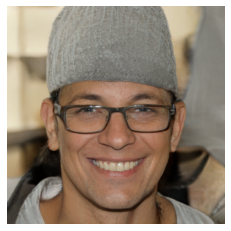

Seed 1001


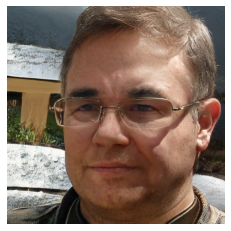

Seed 1002


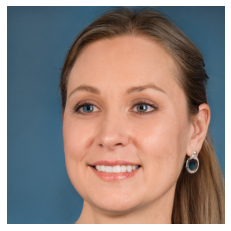

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1003

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## Examining the Latent Vector

Figure shows the effects of transforming the latent vector between two images. This transformation is accomplished by moving one 512-value latent vector slowly to the other 512 vector.  Images that have similar latent vectors will appear similarly to each other.  A high-dimension point between two latent vectos will appear similar to both of the two endpoint latent vectors.

**Figure: Transforming the Latent Vector**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...
(1, 512)


The following code will move between the provided seeds.  The constant STEPS specify how many frames there should be between each of the seeds.

In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [1000,1003,1001]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

Download the generated video.

In [ ]:
from google.colab import files
files.download('movie.mp4')

FileNotFoundError: ignored